In [1]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

from utils import visualize_cam, Normalize
from gradcam import GradCAM, GradCAMpp

In [ ]:
img_name = '../../abba6.jpg'
# img_name = '../water-bird.JPEG'
pil_img = PIL.Image.open(img_name)
pil_img

FileNotFoundError: [Errno 2] No such file or directory: '../abba6.jpg'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
normed_torch_img = torch_img

/tmp/ipykernel_47358/2896765491.py:2: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/torch/csrc/utils/tensor_numpy.cpp:206.)
  torch_img = torch.from_numpy(np.asarray(pil_img)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
/tmp/ipykernel_47358/2896765491.py:3: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)


In [ ]:
vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda()

cam_dict = dict()

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

/home/cat/miniconda3/envs/gradcam/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cat/miniconda3/envs/gradcam/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


saliency_map size : torch.Size([14, 14])
saliency_map size : torch.Size([14, 14])


/home/cat/miniconda3/envs/gradcam/lib/python3.12/site-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


In [ ]:
images = []

a_mask_pp = None
a_mask = None

for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

    a_mask_pp = mask_pp
    a_mask = mask
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    


/home/cat/uni/bakis/gradcam/gradcam.py:103: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
/home/cat/uni/bakis/gradcam/gradcam.py:182: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)


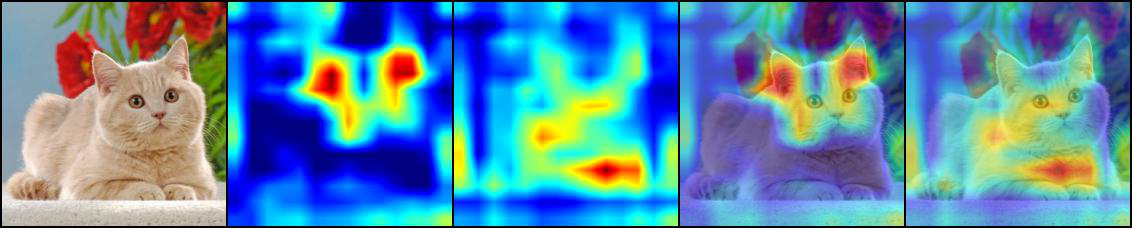

In [ ]:
os.makedirs("output", exist_ok=True)
output_path = os.path.join("output", img_name)

images2 = make_grid(torch.cat(images, 0), nrow=5)

save_image(images2, output_path)
PIL.Image.open(output_path)

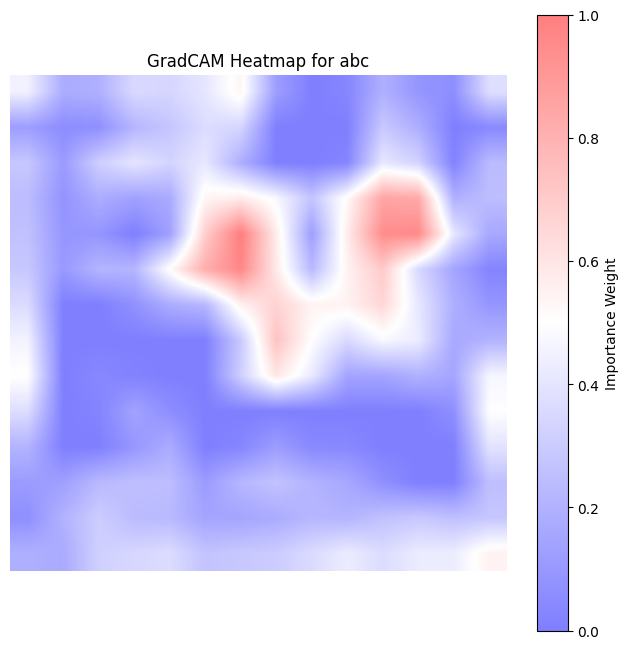

In [ ]:
import matplotlib.pyplot as plt

# Normalize the mask values if needed
vmin, vmax = 0, 1  # Or set based on np.percentile(norm_mask, [1, 99]) for better contrast

top_label_name = "abc" #imagenet_classes[top_label]

plt.figure(figsize=(8, 8))
plt.imshow(a_mask.squeeze().cpu().numpy(), cmap='bwr', alpha=0.5, vmin=vmin, vmax=vmax)  # Overlay only

# plt.imshow(a_mask.squeeze().cpu().numpy(), cmap='bwr', alpha=1, vmin=-1, vmax=vmax)  # This has only red, not sure yet which scheme to apply.

plt.title(f"GradCAM Heatmap for {top_label_name}")
plt.axis('off')
plt.colorbar(label='Importance Weight')
plt.show()